# fpgaConvNet Optimiser Tutorial

The [fpgaConvNet Optimiser](https://github.com/AlexMontgomerie/fpgaconvnet-optimiser) is the frontend for generating the dataflow hardware configuration for a given convolutional neural network. In this tutorial, The main aspects to this optimiser will be covered. A step by step guide of stages to the model to hardware description is given. Instructions on using the command-line interface are given towards the end.

## 1. Initialising a Hardware Model

The first step is parsing the CNN model into an initial hardware model. This initial hardware model is a very basic implementation, which maps the CNN layers to their hardware equivalent. 

The first step is to intialise a `Network` model. This class the top-level in the hierarchy of hardware model abstractions.

In [1]:
# setup environment
!python -m pip install fpgaconvnet-optimiser-AlexMontgomerie
!wget https://www.dropbox.com/s/9ua1diq2fd254ab/lenet.onnx
!mkdir figures
from IPython.display import Image

     |████████████████████████████████| 92kB 5.4MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
     |████████████████████████████████| 276kB 41.6MB/s 
     |████████████████████████████████| 1.0MB 42.4MB/s 
     |████████████████████████████████| 14.5MB 318kB/s 
     |████████████████████████████████| 12.8MB 42.3MB/s 
     |████████████████████████████████| 4.1MB 44.8MB/s 
     |████████████████████████████████| 14.5MB 184kB/s 
     |████████████████████████████████| 25.9MB 69.6MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=a3117755ba4cb67ecaad91595b5e339a2f2ba4309b3645b1c6b0437a70d508c0
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built pyyaml
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2

data
['conv1', 'pool1', 'conv2', 'pool2', 'pool2_5_flattened', 'ip1_6relu1', 'ip1', 'ip1_7_flattened', 'ip2']


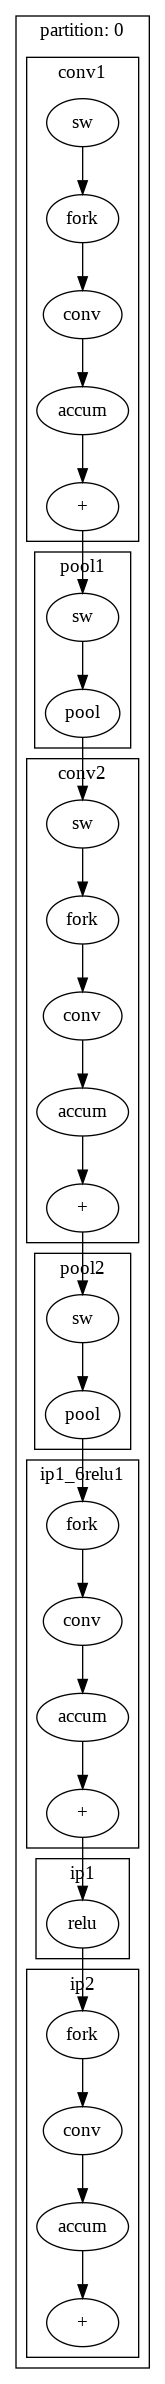

In [18]:
from fpgaconvnet_optimiser.models.network import Network

# create network
lenet = Network("lenet", "lenet.onnx")
lenet.update_partitions()

# visualise network
lenet.visualise("figures/lenet_baseline.png")
Image(filename="figures/lenet_baseline.png") 

all horizontal splits:  [('conv1', 'pool1'), ('pool1', 'conv2'), ('conv2', 'pool2'), ('pool2', 'ip1_6relu1'), ('ip1_6relu1', 'ip1'), ('ip1', 'ip2')]


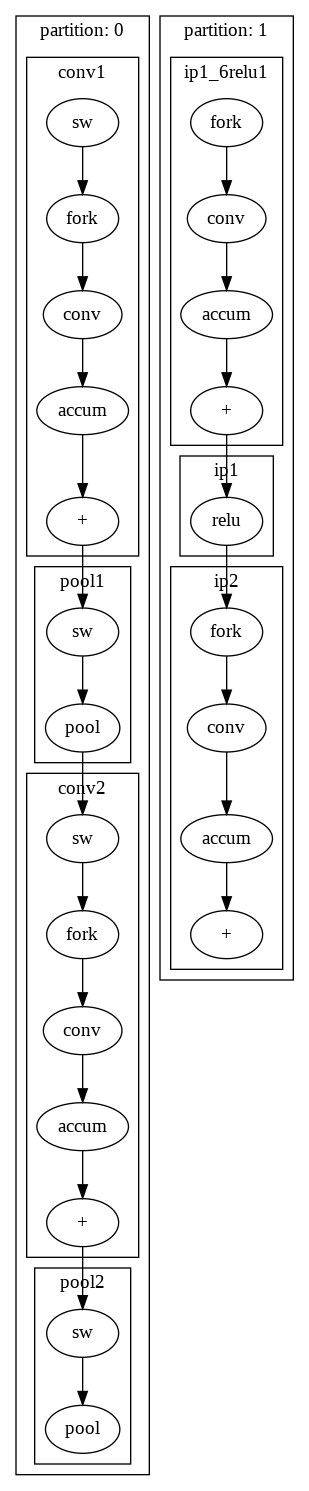

In [19]:
# get all avaiable partitions
print("all horizontal splits: ", lenet.get_all_horizontal_splits(0))

# split all partitions
lenet.split_horizontal(0,("pool2","ip1_6relu1"))

# visualise network
lenet.visualise("figures/lenet_partitioned.png")
Image(filename="figures/lenet_partitioned.png") 

In [20]:
# show rates before
print(f"latency conv1 (fine = {lenet.partitions[0].graph.nodes['conv1']['hw'].fine}) : {lenet.partitions[0].graph.nodes['conv1']['hw'].get_latency()}")
print(f"latency conv2 (fine = {lenet.partitions[0].graph.nodes['conv2']['hw'].fine}) : {lenet.partitions[0].graph.nodes['conv2']['hw'].get_latency()}")

# get possible fine factors
print("possible fine (conv1): ", lenet.partitions[0].graph.nodes['conv1']['hw'].get_fine_feasible())
print("possible fine (conv2): ", lenet.partitions[0].graph.nodes['conv2']['hw'].get_fine_feasible())

# update fine factors
lenet.partitions[0].graph.nodes['conv1']['hw'].fine = 25
lenet.partitions[0].graph.nodes['conv2']['hw'].fine = 25
lenet.update_partitions()

# show updated rates
print(f"latency conv1 (fine = {lenet.partitions[0].graph.nodes['conv1']['hw'].fine}) : {lenet.partitions[0].graph.nodes['conv1']['hw'].get_latency()}")
print(f"latency conv2 (fine = {lenet.partitions[0].graph.nodes['conv2']['hw'].fine}) : {lenet.partitions[0].graph.nodes['conv2']['hw'].get_latency()}")

latency conv1 (fine = 1) : 288000.0
latency conv2 (fine = 1) : 1599999.9999999998
possible fine (conv1):  [1, 5, 25]
possible fine (conv2):  [1, 5, 25]
rate in conv1 (fine = 25) : 11520.000000000002
rate in conv2 (fine = 25) : 2880.0


In [ ]:
# update coarse factors

## conv1
lenet.partitions[0].graph.nodes['conv1']['hw'].update_coarse_out(5)

## pool1
lenet.partitions[0].graph.nodes['pool1']['hw'].update_coarse_in(5)

## conv2
lenet.partitions[0].graph.nodes['conv2']['hw'].update_coarse_in(5)
lenet.partitions[0].graph.nodes['conv2']['hw'].update_coarse_out(10)

## pool2
lenet.partitions[0].graph.nodes['pool2']['hw'].update_coarse_in(10)

lenet.update_partitions()

# visualise network
lenet.visualise("figures/lenet_coarse.png")
Image(filename="figures/lenet_coarse.png") 